In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [ ]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data

X, y = read_data('data/english.csv', flavor=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [12]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [ ]:
from fgclassifier.features import FeaturePipeline, fm_spec_en, logger

for name in ['count', 'tfidf',
             'lsa_200', 'lsa_500', 'lsa_1k',
             'count_sv', 'tfidf_sv', 'tfidf_sv_dense',
             'lsa_200_sv', 'lsa_500_sv']:
    logger.info(f'Building features for {name}...')
    model = FeaturePipeline.from_spec(name, spec=fm_spec_en, cache=fm)
    model.fit_transform(X_train)
    model.transform(X_test)

2018-11-21 18:01:28,154 [INFO] Building features for count...
2018-11-21 18:01:28,155 [INFO] Fit & Transform CountVectorizer...
2018-11-21 18:01:43,147 [INFO] Vocab Size: 1824
2018-11-21 18:01:44,270 [INFO] Building features for tfidf...
2018-11-21 18:01:44,272 [INFO]   count: fit_transform use cache.
2018-11-21 18:01:44,272 [INFO] Fit & Transform TF-IDF...
2018-11-21 18:01:44,319 [INFO]   count: transform use cache.
2018-11-21 18:01:44,330 [INFO] Building features for lsa_200...
2018-11-21 18:01:44,332 [INFO]   tfidf: fit_transform use cache.
2018-11-21 18:01:44,333 [INFO] Fit & Transform TruncatedSVD...
2018-11-21 18:01:45,480 [INFO]   tfidf: transform use cache.
2018-11-21 18:01:45,512 [INFO] Building features for lsa_500...
2018-11-21 18:01:45,513 [INFO]   tfidf: fit_transform use cache.
2018-11-21 18:01:45,514 [INFO] Fit & Transform TruncatedSVD...
2018-11-21 18:01:49,295 [INFO]   tfidf: transform use cache.
2018-11-21 18:01:49,356 [INFO] Building features for lsa_1k...
2018-11-21

Exam the quality of the top terms:

In [6]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count', 'count_sv']:
    model = fm[mn]['model'].named_steps[mn]
    x_train = fm[mn]['train']
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.2f, max_df: %.2f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:10]]))

Data Shape: (7500,) (2500,)


AttributeError: 'FeaturePipeline' object has no attribute 'vocabulary_'

In [8]:
fm['tfidf']['model'].named_steps

{'count': FeaturePipeline(cache={'model': FeaturePipeline(cache={...}, spec=None,
         steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=0.01,
         n...atrix of type '<class 'numpy.int64'>'
 	with 191343 stored elements in Compressed Sparse Row format>},
         spec=None,
         steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=0.01,
         ngram_range=(1, 5), preprocessor=None, stop_words='english',
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None))]),
 'tfidf': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)}

## The Very Basic TF-IDF + LDA classifier

In [9]:
from fgclassifier.baseline import Baseline
from fgclassifier.classifiers import LDA

# Linear Discriminant Analysis
model = Baseline(classifier=LDA)
model.fit(fm['lsa_1k']['train'], y_train)
model.score(fm['lsa_1k']['test'], y_test)

2018-11-21 13:43:36,186 [INFO] [Validate]: F1 Scores
2018-11-21 13:43:36,189 [INFO]   location_traffic_convenience            	0.4655
2018-11-21 13:43:36,197 [INFO]   location_distance_from_business_district	0.3495
2018-11-21 13:43:36,200 [INFO]   location_easy_to_find                   	0.4082
2018-11-21 13:43:36,204 [INFO]   service_wait_time                       	0.4325
2018-11-21 13:43:36,207 [INFO]   service_waiters_attitude                	0.5656
2018-11-21 13:43:36,213 [INFO]   service_parking_convenience             	0.5036
2018-11-21 13:43:36,218 [INFO]   service_serving_speed                   	0.5345
2018-11-21 13:43:36,223 [INFO]   price_level                             	0.5415
2018-11-21 13:43:36,228 [INFO]   price_cost_effective                    	0.4309
2018-11-21 13:43:36,233 [INFO]   price_discount                          	0.4755
2018-11-21 13:43:36,241 [INFO]   environment_decoration                  	0.4662
2018-11-21 13:43:36,247 [INFO]   environment_noise      

0.45698584855746177

## Search for the Best Feature + Classifier Combination

In [10]:
# Run for all classifiers and feature builders
all_avg_scores, all_scores = defaultdict(dict), defaultdict(dict)

In [12]:
from fgclassifier.train import fm_cross_check

conf = {
    'fm_cache': fm,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'avg': all_avg_scores,
        'all': all_scores
    }
}

# We'd only need to run the dummy models on one feature model,
# as they do not care about the features
# fm_cross_check(
#     ['tfidf'],
#     ['DummyStratified', 'DummyMostFrequent'], **conf)

# Naive Bayes models cannot handle negative values, so we pass
# in only tfidf features
# fm_cross_check(
#     ['tfidf', 'tfidf_sv'],
#     ['MultinomialNB', 'ComplementNB'], **conf)

# All other models can run on many classifiers
results = fm_cross_check(
    [#'lsa_200', 'lsa_500', 'lsa_1k',
     #'tfidf_sv_dense',
     'lsa_200_sv', 'lsa_500_sv',
    ],
    ['LDA', 'LinearSVC', 'Logistic', 'Ridge'], **conf)

2018-11-21 13:52:28,324 [INFO] 
2018-11-21 13:52:28,325 [INFO] ============ Feature Model: lsa_200_sv ============
2018-11-21 13:52:28,326 [INFO] Train for lsa_200_sv -> LDA...
2018-11-21 13:52:34,367 [INFO] [Validate]: F1 Scores
2018-11-21 13:52:34,369 [INFO]   location_traffic_convenience            	0.4267
2018-11-21 13:52:34,372 [INFO]   location_distance_from_business_district	0.2943
2018-11-21 13:52:34,376 [INFO]   location_easy_to_find                   	0.3501
2018-11-21 13:52:34,379 [INFO]   service_wait_time                       	0.3547
2018-11-21 13:52:34,383 [INFO]   service_waiters_attitude                	0.5262
2018-11-21 13:52:34,386 [INFO]   service_parking_convenience             	0.4647
2018-11-21 13:52:34,389 [INFO]   service_serving_speed                   	0.4440
2018-11-21 13:52:34,392 [INFO]   price_level                             	0.4877
2018-11-21 13:52:34,396 [INFO]   price_cost_effective                    	0.4105
2018-11-21 13:52:34,399 [INFO]   price_di

2018-11-21 13:53:02,101 [INFO]   environment_cleaness                    	0.3584
2018-11-21 13:53:02,103 [INFO]   dish_portion                            	0.2808
2018-11-21 13:53:02,105 [INFO]   dish_taste                              	0.3160
2018-11-21 13:53:02,108 [INFO]   dish_look                               	0.2531
2018-11-21 13:53:02,110 [INFO]   dish_recommendation                     	0.2896
2018-11-21 13:53:02,112 [INFO]   others_overall_experience               	0.3584
2018-11-21 13:53:02,114 [INFO]   others_willing_to_consume_again         	0.2917
2018-11-21 13:53:02,115 [INFO] ---------------------------------------------------
2018-11-21 13:53:02,116 [INFO] 【lsa_200_sv -> Ridge】: 0.3378
2018-11-21 13:53:02,117 [INFO] ---------------------------------------------------
2018-11-21 13:53:02,118 [INFO] 
2018-11-21 13:53:02,119 [INFO] ============ Feature Model: lsa_500_sv ============
2018-11-21 13:53:02,120 [INFO] Train for lsa_500_sv -> LDA...
2018-11-21 13:53:19,181 [INFO

2018-11-21 13:54:15,912 [INFO]   price_level                             	0.4491
2018-11-21 13:54:15,917 [INFO]   price_cost_effective                    	0.3295
2018-11-21 13:54:15,919 [INFO]   price_discount                          	0.4372
2018-11-21 13:54:15,925 [INFO]   environment_decoration                  	0.3834
2018-11-21 13:54:15,928 [INFO]   environment_noise                       	0.3613
2018-11-21 13:54:15,931 [INFO]   environment_space                       	0.3444
2018-11-21 13:54:15,935 [INFO]   environment_cleaness                    	0.3826
2018-11-21 13:54:15,939 [INFO]   dish_portion                            	0.2890
2018-11-21 13:54:15,944 [INFO]   dish_taste                              	0.3407
2018-11-21 13:54:15,949 [INFO]   dish_look                               	0.2728
2018-11-21 13:54:15,953 [INFO]   dish_recommendation                     	0.2806
2018-11-21 13:54:15,956 [INFO]   others_overall_experience               	0.3863
2018-11-21 13:54:15,962 [INF

In [26]:
rows = {}
for fm_name in all_scores:
    for clf_name in all_scores[fm_name]:
        key = f'{fm_name}.{clf_name}'
        rows[key] = [all_avg_scores[fm_name][clf_name],
                     *all_scores[fm_name][clf_name]]
df = pd.DataFrame(rows)
df.index = ['average', *y_train.columns]
df = df.T.sort_values('average', ascending=False)
df

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
tfidf_sv_dense.LDA,0.459859,0.466292,0.340962,0.410272,0.412732,0.572884,0.515427,0.530130,0.548450,0.455290,...,0.458143,0.572426,0.498306,0.484644,0.370326,0.483179,0.367013,0.367459,0.470756,0.383674
lsa_1k.LDA,0.456986,0.465547,0.349524,0.408242,0.432522,0.565634,0.503633,0.534527,0.541547,0.430915,...,0.466235,0.564430,0.489781,0.470938,0.363119,0.507684,0.341947,0.346304,0.461561,0.420101
lsa_500_sv.LDA,0.446142,0.452126,0.332940,0.362586,0.413302,0.558365,0.493694,0.535689,0.520326,0.435517,...,0.437708,0.534942,0.437979,0.475941,0.378924,0.497902,0.367151,0.357311,0.453751,0.390350
lsa_500.LDA,0.442798,0.449717,0.340970,0.388428,0.426325,0.571438,0.481700,0.502474,0.518378,0.427563,...,0.435676,0.495541,0.439109,0.449298,0.378296,0.498215,0.347646,0.366673,0.444834,0.404123
tfidf_sv_dense.LinearSVC,0.421411,0.442215,0.336579,0.361738,0.379089,0.554437,0.411494,0.483994,0.527506,0.383646,...,0.451426,0.506178,0.470011,0.417699,0.343321,0.465163,0.305578,0.325279,0.443375,0.349842
lsa_200.LDA,0.413761,0.427406,0.296298,0.348342,0.370238,0.542976,0.504729,0.437888,0.495490,0.396998,...,0.405455,0.404446,0.409809,0.419106,0.356321,0.504965,0.313621,0.348483,0.433009,0.383575
lsa_1k.LinearSVC,0.411947,0.431471,0.349268,0.345267,0.355385,0.553565,0.383416,0.458079,0.514978,0.367559,...,0.430784,0.467372,0.437523,0.425196,0.353270,0.476231,0.309182,0.323258,0.435183,0.352833
lsa_200_sv.LDA,0.410410,0.426715,0.294336,0.350145,0.354701,0.526158,0.464712,0.444027,0.487734,0.410496,...,0.398200,0.418687,0.413156,0.414663,0.353647,0.494925,0.308060,0.361172,0.432504,0.376673
lsa_500_sv.LinearSVC,0.401838,0.430778,0.321327,0.339602,0.321228,0.535886,0.418679,0.472155,0.503553,0.377960,...,0.416423,0.451538,0.382329,0.395676,0.349385,0.474460,0.291332,0.323711,0.438231,0.330647
lsa_500.LinearSVC,0.395076,0.430334,0.328574,0.341176,0.315404,0.539808,0.390591,0.446948,0.498862,0.365599,...,0.401723,0.411668,0.395892,0.396609,0.341277,0.460973,0.289092,0.324302,0.431167,0.322428


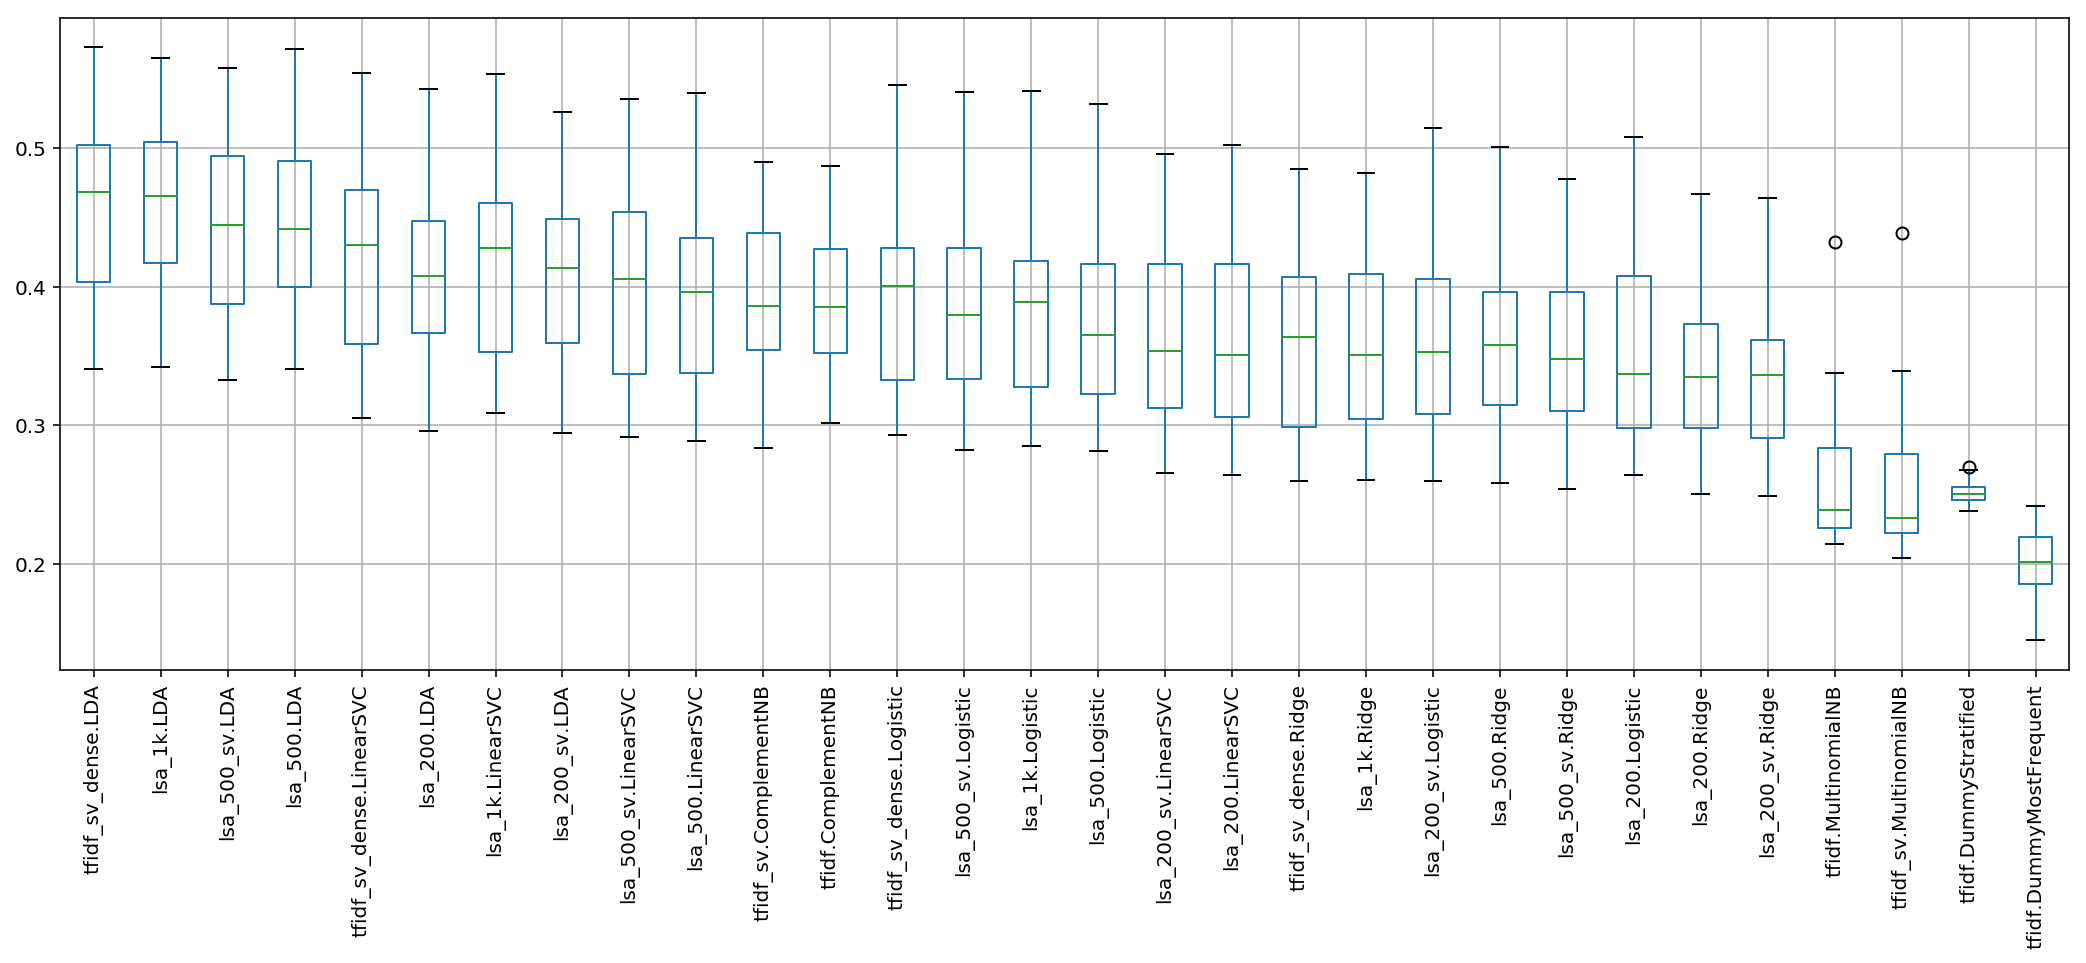

In [28]:
import matplotlib.pyplot as plt

df.T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.